In [1]:
import os
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

2025-05-16 14:13:40.733810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747422820.798751    6537 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747422820.823594    6537 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747422820.936517    6537 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747422820.936538    6537 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747422820.936539    6537 computation_placer.cc:177] computation placer alr

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", path)

/home/saniago/Documentos/Projects/DockerBreastCancer/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/saniago/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


In [3]:
# Dataset: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

base_dir = '/home/saniago/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8'
img_size = (224, 224)
batch_size = 32

In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(f'number of classes in {folder_name} folder : {len(classes)}')

In [6]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 36
number of classes in validation folder : 36
number of classes in test folder : 36


In [7]:
classes = [class_name for class_name in os.listdir(train_dir)]
def create_df(folder_path) :
    all_images = []    
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [8]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [9]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,                  
    shuffle=True,
    seed=42,
    
)

Found 3115 validated image filenames belonging to 36 classes.


In [10]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 351 validated image filenames belonging to 36 classes.


In [11]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 359 validated image filenames belonging to 36 classes.


In [12]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Congela el modelo base

W0000 00:00:1747422824.366533    6537 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

2025-05-16 14:13:44.989638: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.
2025-05-16 14:13:45.004458: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.
2025-05-16 14:13:45.016323: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.


In [14]:
from tensorflow.keras import optimizers

In [15]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

In [16]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True) 

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [17]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

/home/saniago/Documentos/Projects/DockerBreastCancer/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-05-16 14:13:47.733571: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.
2025-05-16 14:13:49.731241: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17661952 exceeds 10% of free system memory.


 4/98 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.0332 - loss: 11.4980

/home/saniago/Documentos/Projects/DockerBreastCancer/env/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3009 - loss: 6.5146

/home/saniago/Documentos/Projects/DockerBreastCancer/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.3025 - loss: 6.4836 - val_accuracy: 0.8148 - val_loss: 0.5951 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7248 - loss: 1.0592 - val_accuracy: 0.8462 - val_loss: 0.4806 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7615 - loss: 0.8571 - val_accuracy: 0.8547 - val_loss: 0.4514 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7886 - loss: 0.7035 - val_accuracy: 0.8946 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8066 - loss: 0.6512 - val_accuracy: 0.9060 - val_loss: 0.2936 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8299 - loss: 0.5332 - val_accuracy: 0.9031 - val_loss: 0.3364 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8412 - loss: 0.4819 - val_accuracy: 0.86

In [20]:
loss, accuracy = model.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 906ms/step - accuracy: 0.9821 - loss: 0.0870
Pérdida en el conjunto de prueba: 0.15247102081775665
Precisión en el conjunto de prueba: 0.9721448421478271


In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(test_generator.classes, np.argmax(model.predict(test_generator), axis=-1)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 968ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        10
           8       0.77      1.00      0.87        10
           9       0.88      0.70      0.78        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       0.91      1.00      0.95        10
          16       1.00      1.00      

In [25]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
36,0.976244,0.063113,0.965812,0.158610,0.000008
37,0.978170,0.063713,0.968661,0.158698,0.000004
38,0.976886,0.061637,0.965812,0.159295,0.000004
39,0.977528,0.063719,0.965812,0.158556,0.000004
40,0.981380,0.056122,0.965812,0.158782,0.000002


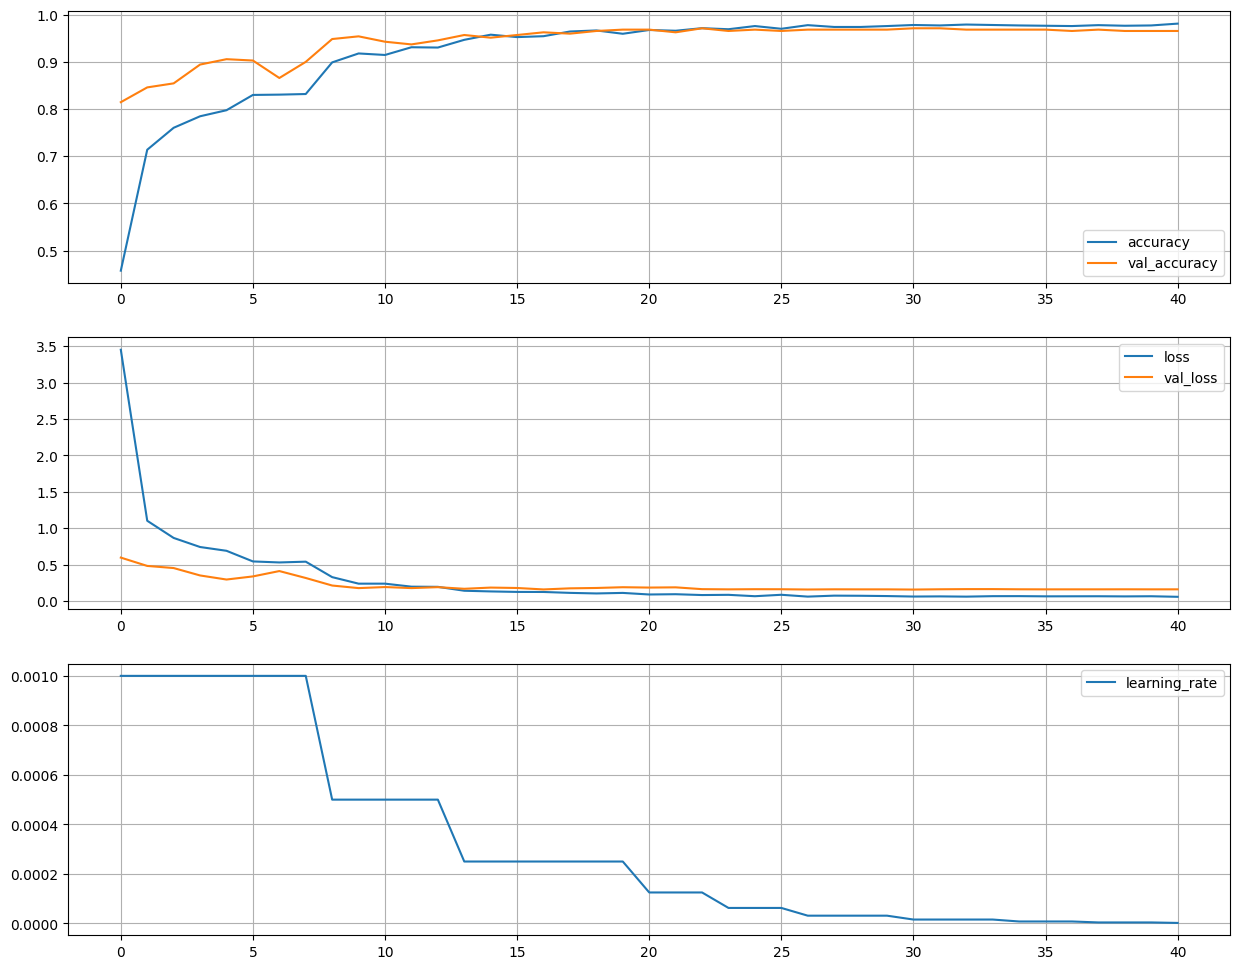

In [26]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

ax[0].plot(x, result_df['accuracy'], label='accuracy')
ax[0].plot(x, result_df['val_accuracy'], label='val_accuracy')
ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].plot(x, result_df['loss'], label='loss')
ax[1].plot(x, result_df['val_loss'], label='val_loss')
ax[1].legend(loc='best')
ax[1].grid(True)

ax[2].plot(x, result_df['learning_rate'], label='learning_rate')
ax[2].legend(loc='best')
ax[2].grid(True)

plt.show()

In [28]:
best_model = models.load_model('MyModel.keras')

In [29]:
# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 936ms/step - accuracy: 0.9821 - loss: 0.0870
Test Loss: 0.15247102081775665
Test Accuracy: 0.9721448421478271


### Algunas pruebas

In [39]:
import numpy as np
from PIL import Image

# Probar el modelo con una imagen
image_path = './09.jpg'
img = Image.open(image_path).convert("RGB")
img = img.resize((224, 224))
img_array = np.array(img, dtype=np.float32)
img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión para batch
img_array /= 255.0  # Normalizar entre 0 y 1

predictions = best_model.predict(img_array)

# Decodificar la predicción
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invertir el diccionario
predicted_class_index = np.argmax(predictions[0])      # Índice de la clase con mayor probabilidad
predicted_class = class_labels[predicted_class_index]  # Nombre de la clase

print(f"La imagen pertenece a la clase: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
La imagen pertenece a la clase: apple
